<a href="https://colab.research.google.com/github/jacobdwatters/NIOSH-Project/blob/main/BreakpointClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from numpy.random import seed
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score, roc_auc_score, mean_absolute_error, mean_squared_error, recall_score, f1_score, precision_score
from numpy.linalg import lstsq

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

import scipy as sp
from scipy import stats

import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path_after_2010 = '/content/gdrive/My Drive/NIOSH Project/data/violations_processed_after_2010.csv'
violation_data = pd.read_csv(path_after_2010)

In [ ]:
FEATURES = ['YEAR_OCCUR', 'VIOLATOR_VIOLATION_CNT',
'VIOLATOR_INSPECTION_DAY_CNT', 'MINE_TYPE',
'PRIMARY_OR_MILL', 'COAL_METAL_IND', 'VIOLATOR_TYPE_CD']
TARGETS = ['PROPOSED_PENALTY']

X = violation_data[FEATURES]
y = violation_data[TARGETS]

In [ ]:
# Define which columns should be encoded vs scaled
columns_to_encode = ['MINE_TYPE', 'COAL_METAL_IND', 'PRIMARY_OR_MILL', 'VIOLATOR_TYPE_CD']
columns_to_scale  = ['VIOLATOR_VIOLATION_CNT', 'VIOLATOR_INSPECTION_DAY_CNT', 'YEAR_OCCUR']

# Instantiate encoder/scaler
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False)

y = np.array(y)

# Scale and Encode Separate Columns
scaled_columns  = scaler.fit_transform(X[columns_to_scale])
encoded_columns = ohe.fit_transform(X[columns_to_encode])

# Concatenate (Column-Bind) Processed Columns Back Together
X_pre = np.concatenate([scaled_columns, encoded_columns], axis=1)
np.nan_to_num(X_pre, copy=False)

print('Features shape:', X_pre.shape)

Features shape: (1429135, 24)


In [ ]:
n_bins = 1000
hist_freq, hist_ends = np.histogram(y.T[0], bins=n_bins)
# get midpoints
hist_x = (hist_ends[:n_bins] + hist_ends[1:]) / 2
len(hist_x), len(hist_freq)

(1000, 1000)

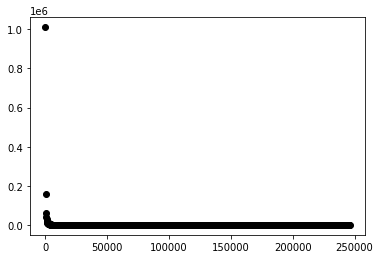

In [ ]:
plt.plot(hist_x, hist_freq, 'ok')

In [ ]:
# source: https://datascience.stackexchange.com/a/32833

ramp = lambda u: np.maximum( u, 0 )
step = lambda u: ( u > 0 ).astype(float)

def SegmentedLinearReg( X, Y, breakpoints ):
    nIterationMax = 10

    breakpoints = np.sort( np.array(breakpoints) )

    dt = np.min( np.diff(X) )
    ones = np.ones_like(X)

    for i in range( nIterationMax ):
        # Linear regression:  solve A*p = Y
        Rk = [ramp( X - xk ) for xk in breakpoints ]
        Sk = [step( X - xk ) for xk in breakpoints ]
        A = np.array([ ones, X ] + Rk + Sk )
        p =  lstsq(A.transpose(), Y, rcond=None)[0]

        # Parameters identification:
        a, b = p[0:2]
        ck = p[ 2:2+len(breakpoints) ]
        dk = p[ 2+len(breakpoints): ]

        # Estimation of the next break-points:
        newBreakpoints = breakpoints - dk/ck

        # Stop condition
        if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
            break

        breakpoints = newBreakpoints
    else:
        print( 'maximum iteration reached' )

    # Compute the final segmented fit:
    Xsolution = np.insert( np.append( breakpoints, max(X) ), 0, min(X) )
    ones =  np.ones_like(Xsolution)
    Rk = [ c*ramp( Xsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

    Ysolution = a*ones + b*Xsolution + np.sum( Rk, axis=0 )

    return Xsolution, Ysolution, breakpoints


Breakpoints: [514.88125587]


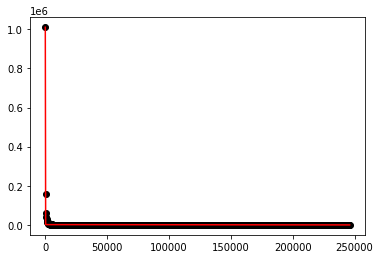

In [ ]:
initialBreakpoints = [700]
plt.plot(hist_x, hist_freq, 'ok')
x_seg, y_seg, breakpoints = SegmentedLinearReg( hist_x, hist_freq, initialBreakpoints )
plt.plot(x_seg, y_seg, '-r' );
print(f'Breakpoints: {breakpoints}')

In [ ]:
y_categories = y > breakpoints[0]
pd.Series(y_categories.T[0]).value_counts()

False    1102739
True      326396
dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pre, y_categories, test_size = 0.25, random_state = 0)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_train shape:', y_test.shape)

X_train shape: (1071851, 24)
X_test shape: (357284, 24)
y_train shape: (1071851, 1)
y_train shape: (357284, 1)


In [ ]:
batch_size = 2**14
epochs = 120

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model_breakpoint = keras.Sequential()

model_breakpoint.add(keras.Input(shape = (len(X_train[0]), ) ))
model_breakpoint.add(layers.Dense(64, activation="relu"))
model_breakpoint.add(layers.Dense(32, activation="relu"))
model_breakpoint.add(layers.Dense(16, activation="relu"))
model_breakpoint.add(layers.Dense(8, activation="relu"))
model_breakpoint.add(layers.Dense(8, activation="relu"))
model_breakpoint.add(layers.Dense(8, activation="relu"))
model_breakpoint.add(layers.Dense(1, activation="sigmoid"))


opt = keras.optimizers.Adam(learning_rate=0.01)
model_breakpoint.compile(loss="binary_crossentropy", optimizer=opt)
history = model_breakpoint.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/120
66/66 [==============================] - 3s 33ms/step - loss: 0.3705 - val_loss: 0.2996
Epoch 2/120
66/66 [==============================] - 2s 29ms/step - loss: 0.2803 - val_loss: 0.2589
Epoch 3/120
66/66 [==============================] - 2s 31ms/step - loss: 0.2507 - val_loss: 0.2371
Epoch 4/120
66/66 [==============================] - 2s 29ms/step - loss: 0.2351 - val_loss: 0.2262
Epoch 5/120
66/66 [==============================] - 2s 29ms/step - loss: 0.2292 - val_loss: 0.2317
Epoch 6/120
66/66 [==============================] - 2s 31ms/step - loss: 0.2212 - val_loss: 0.2192
Epoch 7/120
66/66 [==============================] - 2s 30ms/step - loss: 0.2169 - val_loss: 0.2101
Epoch 8/120
66/66 [==============================] - 2s 29ms/step - loss: 0.2139 - val_loss: 0.2078
Epoch 9/120
66/66 [==============================] - 3s 39ms/step - loss: 0.2084 - val_loss: 0.2040
Epoch 10/120
66/66 [==============================] - 4s 55ms/step - loss: 0.2064 - val_loss: 0.2071

In [ ]:
y_pred = model_breakpoint.predict(X_test)
print(tf.metrics.binary_accuracy(y_test, y_pred))

11166/11166 [==============================] - 19s 2ms/step
tf.Tensor([1. 1. 1. ... 1. 1. 1.], shape=(357284,), dtype=float32)


In [ ]:
bin_acc = tf.metrics.binary_accuracy(y_test, y_pred)
print(np.sum(bin_acc) / len(bin_acc))

0.9254738527333998


In [ ]:
X_lower = X_pre[(y < breakpoints[0])[:, 0]]
y_lower = y[y < breakpoints[0]]
X_upper = X_pre[(y >= breakpoints[0])[:, 0]]
y_upper = y[y >= breakpoints[0]]

X_train_lower, X_test_lower, y_train_lower, y_test_lower = train_test_split(X_lower, y_lower, test_size = 0.25, random_state = 0)
X_train_upper, X_test_upper, y_train_upper, y_test_upper = train_test_split(X_upper, y_upper, test_size = 0.25, random_state = 0)

print('X_train_lower shape:', X_train_lower.shape)
print('X_test_lower shape:', X_test_lower.shape)
print('y_train_lower shape:', y_train_lower.shape)
print('y_train_lower shape:', y_test_lower.shape)

print('X_train_upper shape:', X_train_upper.shape)
print('X_test_upper shape:', X_test_upper.shape)
print('y_train_upper shape:', y_train_upper.shape)
print('y_train_upper shape:', y_test_upper.shape)

X_train_lower shape: (827054, 24)
X_test_lower shape: (275685, 24)
y_train_lower shape: (827054,)
y_train_lower shape: (275685,)
X_train_upper shape: (244797, 24)
X_test_upper shape: (81599, 24)
y_train_upper shape: (244797,)
y_train_upper shape: (81599,)


In [ ]:
def scheduler(epoch, lr):
  if epoch < 85:
    return lr
  else: # Drop learning rate after the first 85 epochs
    return lr*np.exp(-0.05)

In [ ]:

batch_size = 2**14
epochs = 120
callback_lower = tf.keras.callbacks.LearningRateScheduler(scheduler)

model_lower = keras.Sequential()

model_lower.add(keras.Input(shape = (len(X_train[0]), ) ))
model_lower.add(layers.Dense(64, activation="relu"))
model_lower.add(layers.Dense(32, activation="relu"))
model_lower.add(layers.Dense(16, activation="relu"))
model_lower.add(layers.Dense(8, activation="relu"))
model_lower.add(layers.Dense(8, activation="relu"))
model_lower.add(layers.Dense(8, activation="relu"))
model_lower.add(layers.Dense(1, activation="linear"))


opt = keras.optimizers.Adam(learning_rate=0.01)
model_lower.compile(loss="mse", optimizer=opt)
history_lower = model_lower.fit(X_train_lower, y_train_lower, epochs=epochs, batch_size=batch_size,
                    callbacks=[callback_lower], validation_data=(X_test_lower, y_test_lower))

In [ ]:
callback_upper = tf.keras.callbacks.LearningRateScheduler(scheduler)
model_upper = keras.Sequential()

model_upper.add(keras.Input(shape = (len(X_train[0]), ) ))
model_upper.add(layers.Dense(64, activation="relu"))
model_upper.add(layers.Dense(32, activation="relu"))
model_upper.add(layers.Dense(16, activation="relu"))
model_upper.add(layers.Dense(8, activation="relu"))
model_upper.add(layers.Dense(8, activation="relu"))
model_upper.add(layers.Dense(8, activation="relu"))
model_upper.add(layers.Dense(1, activation="linear"))


opt_upper = keras.optimizers.Adam(learning_rate=0.01)
model_upper.compile(loss="mse", optimizer=opt_upper)
history_upper = model_upper.fit(X_train_upper, y_train_upper, epochs=epochs, batch_size=batch_size,
                    callbacks=[callback_upper], validation_data=(X_test_upper, y_test_upper))

In [ ]:
y_pred_lower = model_lower.predict(X_test_lower)
y_pred_upper = model_upper.predict(X_test_upper)

In [ ]:
r2_lower = r2_score(y_test_lower, y_pred_lower)
mae_lower = mean_absolute_error(y_test_lower, y_pred_lower)
mse_lower = mean_squared_error(y_test_lower, y_pred_lower)
rmse_lower = mean_squared_error(y_test_lower, y_pred_lower, squared=False)

print('lower r2 = %.3f' % r2_lower)
print('lower mae = %.3f' % mae_lower)
print('lower mse = %.3f' % mse_lower)
print('lower rmse = %.3f' % rmse_lower)


print(y_test_upper.shape)
print(y_pred_upper.shape)

r2_upper = r2_score(y_test_upper, y_pred_upper)
mae_upper = mean_absolute_error(y_test_upper, y_pred_upper)
mse_upper = mean_squared_error(y_test_upper, y_pred_upper)
rmse_upper = mean_squared_error(y_test_upper, y_pred_upper, squared=False)

print('upper r2 = %.3f' % r2_upper)
print('upper mae = %.3f' % mae_upper)
print('upper mse = %.3f' % mse_upper)
print('upper rmse = %.3f' % rmse_upper)

8616/8616 [==============================] - 12s 1ms/step
lower r2 = 0.664
2550/2550 [==============================] - 4s 1ms/step
upper r2 = 0.523


In [ ]:
# now combine the breakpoint calculator with the two models to make predictions for all data

def classify_and_predict(X):
    # threshhold of
    predicted_upper_indices = (model_breakpoint.predict(X) > 0.5)
    predicted_lower_indices = np.invert(predicted_upper_indices)

    predicted_upper = X[predicted_upper_indices[:, 0]]
    predicted_lower = X[predicted_lower_indices[:, 0]]

    upper_results = model_upper.predict(predicted_upper)
    lower_results = model_lower.predict(predicted_lower)

    results = np.empty(shape=(X.shape[0], 1))

    results[predicted_upper_indices[:, 0]] = upper_results
    results[predicted_lower_indices[:, 0]] = lower_results

    return results

X_test_concat = np.vstack((X_test_lower, X_test_upper))
y_test_concat = np.hstack((y_test_lower, y_test_upper))

y_pred_concat = classify_and_predict(X_test_concat)

9012/9012 [==============================] - 14s 1ms/step


In [ ]:
r2 = r2_score(y_test_concat, y_pred_concat)
mae = mean_absolute_error(y_test_concat, y_pred_concat)
mse = mean_squared_error(y_test_concat, y_pred_concat)
rmse = mean_squared_error(y_test_concat, y_pred_concat, squared=False)

print('r2 = %.3f' % r2)
print('mae = %.3f' % mae)
print('mse = %.3f' % mse)
print('rmse = %.3f' % rmse)

0.557878890027608